# Rotating neutron star example for O$_2$sclpy

For the underlying C++ code, see the O$_2$scl documentation at
https://awsteiner.org/code/o2scl/html. The Python wrapper,
O$_2$sclpy, is documentated at https://awsteiner.org/code/o2sclpy.
This rotating neutron star code is a Python wrapper to a C++ version
which was, in turn, based on the original RNS code developed by Stergioulas
and Morsink. See
https://awsteiner.org/code/o2scl/html/class/nstar_rot.html for the C++ documentation and https://awsteiner.org/code/o2sclpy-dev/eos.html#class-eos-nstar-rot for the Python interface.

Import necessary modules

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import numpy
import sys
from tqdm import trange, tqdm

In [2]:
plots=True
if 'pytest' in sys.modules:
    plots=False

Get a copy (a pointer to) the O$_2$scl unit conversion object, which
also allows access to the constant library

In [3]:
o2scl_settings=o2sclpy.lib_settings_class()
cu=o2scl_settings.get_convert_units()

## Rotating configuration with a tabulated EOS

Set up an EOS designed with the original RNS code (see
https://awsteiner.org/code/o2scl/html/class/eos_nstar_rot_C.html for the C++ documentation and https://awsteiner.org/code/o2sclpy-dev/eos.html#class-eos-nstar-rot-c for the Python interface).

In [4]:
eC=o2sclpy.eos_nstar_rot_C()
eC.set(True)

Create the rotating neutron star object and set the EOS

In [5]:
nr=o2sclpy.nstar_rot()
nr.verbose=1
nr.set_eos(eC)

Compute a configuration with a fixed central energy density and
a fixed axis ratio

In [6]:
nr.fix_cent_eden_axis_rat(2.0e15,0.59)

Obtain the output as a table3d object. See
https://awsteiner.org/code/o2scl/html/class/table3d.html.

In [7]:
t3d=o2sclpy.table3d()
nr.output_table(t3d)

Output the slice names: ed, pr, h, vsq, rho, gamma, omega, alpha.
Each of these slices is a two-dimensional array of numbers.

In [8]:
for i in range(0,t3d.get_nslices()):
    print(i,t3d.get_slice_name(i))

0 b'ed'
1 b'pr'
2 b'h'
3 b'vsq'
4 b'rho'
5 b'gamma'
6 b'omega'
7 b'alpha'


Print out the gravitational mass

In [9]:
print('Mass: %7.6e' % (nr.Mass/nr.MSUN))

Mass: 2.131250e+00


The final pressure has noise in the region of spacetime occupied by the vacuum, but the pressure elsehwere varies by orders of magnitudes. We use use a cutoff at low pressures to remove the noise.

In [10]:
t3d.function_slice('if(pr>1.0e-12,log10(pr),-12.0)','log10_pr')

Plot the pressure in the internal coordinate system

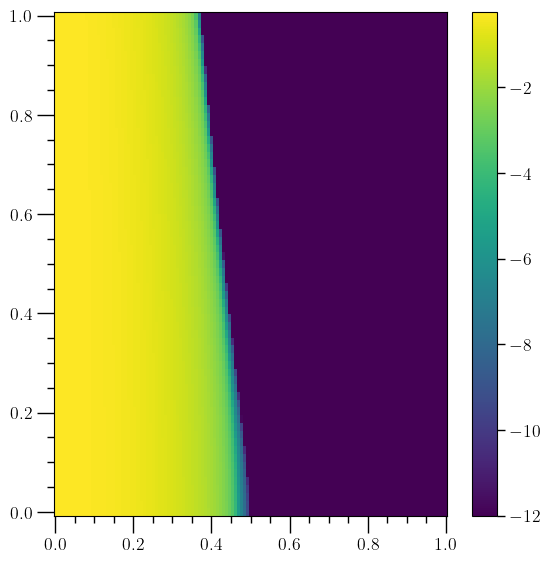

In [11]:
if plots:
    pb=o2sclpy.plot_base()
    pb.fig_dict='fig_size_x=6,fig_size_y=6,dpi=100'
    pb.colbar=True
    pb.den_plot([t3d,'log10_pr'])
    pb.show()
    plot.close()

Create a new table for the output in Cartesian coordinates

In [12]:
t3db=o2sclpy.table3d()
t3db.set_interp_type(o2sclpy.itp_linear)
rad_eq=nr.R_e/1.0e5
coord_grid=o2sclpy.uniform_grid_end.init(0.01,rad_eq*1.1,100)
t3db.set_xy_grid('x',coord_grid,'z',coord_grid)
t3db.line_of_names('ed pr')

Interpolate into Cartesian coordinates (to interpolate 10,000 points takes a minute):

In [13]:
for i in trange(t3db.get_nx()):
    for j in range(0,t3db.get_ny()):
        r=numpy.sqrt(coord_grid[i]**2+coord_grid[j]**2)
        theta=numpy.atan(-coord_grid[j]/coord_grid[i])+numpy.pi/2.0
        t3db.set(i,j,'ed',t3d.interp(r/(r+rad_eq),
                                     numpy.cos(theta),'ed'))
        t3db.set(i,j,'pr',t3d.interp(r/(r+rad_eq),
                                     numpy.cos(theta),'pr'))

100%|█████████████████████████████████████████| 101/101 [00:45<00:00,  2.24it/s]


Take the log carefully so we can plot

In [14]:
t3db.function_slice('if(pr>1.0e-5,log10(pr),-5.0)','log10_pr')

Plot the rotating neutron star, with the equator along the x-axis:

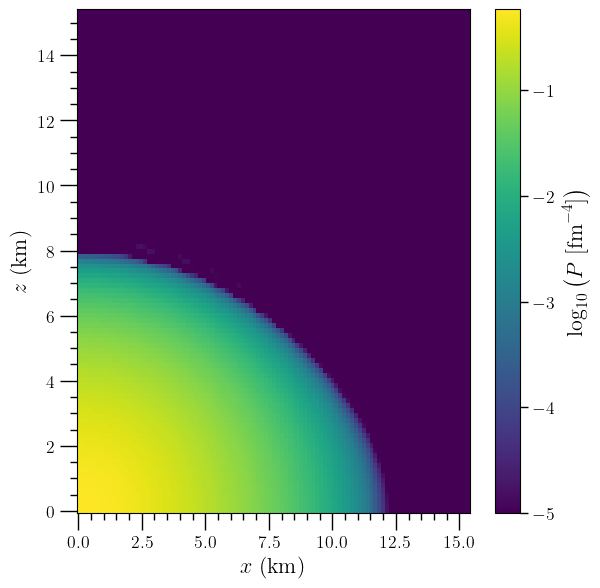

In [15]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.den_plot([t3db,'log10_pr'])
    pb.xtitle(r'$ x~(\mathrm{km}) $')
    pb.ytitle(r'$ z~(\mathrm{km}) $')
    pb.ttext(1.27,0.5,r'$ \log_{10} \left( P~[\mathrm{fm}^{-4}] \right) $',rotation=90)
    pb.show()
    plot.close()

## A rotating neutron star with a more complex EOS

Set up the equation of state of neutron matter near the saturation density. We use the parameterization from Gandolfi et al. (2012) (https://doi.org/10.1103/PhysRevC.85.032801). The values ``a`` and ``b`` are in MeV. The saturation density, ``n0`` is in $ \mathrm{fm}^{-3} $. We begin by setting up the basic variables.

In [16]:
a=13
alpha=0.49
S=32
L=44
b=S-16-a
beta=(L-3*a*alpha)/b/3
n0=0.16

We compute the EOS from baryon densities of $0.08$ to $0.32~\mathrm{fm}^{-3}$. We store EOS in a O$_2$scl ``table_units`` object (see https://awsteiner.org/code/o2scl/html/class/table_units.html). Note we store energy densities and pressures in units of $\mathrm{fm}^{-4}$. 

In [17]:
tab=o2sclpy.table_units()
tab.line_of_names('nb ed pr')
tab.line_of_units('1/fm^3 1/fm^4 1/fm^4')
tab.set_nlines(25)
for i in range(0,25):
    nb=0.08+i*0.01
    tab.set('nb',i,nb)
    tab.set('ed',i,939.0/197.33*nb+(nb*a*(nb/n0)**alpha+
                                    nb*b*(nb/n0)**beta)/197.33)
    tab.set('pr',i,(n0*a*alpha*(nb/n0)**(1.0+alpha)+
                    n0*b*beta*(nb/n0)**(1.0+beta))/197.33)

Compute the energy density and pressure at the highest baryon density currently in the table.

In [18]:
#         n1=3.11681476319e-01
 #       nbtrans=4.31297304991e-01
#        n2=3.61608550927e+00


In [19]:
ed32=tab.get('ed',tab.get_nlines()-1)
pr32=tab.get('pr',tab.get_nlines()-1)

Beginning at $n_B=0.32$, we create a polytrope, with an index of $0.8$. (See https://awsteiner.org/code/o2scl/html/class/eos_tov_polytrope.html.) The coefficient is fixed by ensuring that the energy density and pressure from the lower-density EOS are matched. We use this polytrope up to a transition density of $n_B=0.64~\mathrm{fm}^{-3}$.

In [20]:
n1=3.11681476319e-01
coeff1=pr32/ed32**(1.0+1.0/n1)
p1=o2sclpy.eos_tov_polytrope()
p1.set_coeff_index(coeff1,n1)
p1.set_baryon_density(0.32,ed32)
nbtrans=4.31297304991e-01

Loop over baryon densities and add the polytrope to the table object:

In [21]:
for i in range(1,33):
    nb=0.32+i*(nbtrans-0.32)/32
    tab.line_of_data([nb,p1.ed_from_nb(nb),p1.pr_from_nb(nb)])

Record the last energy density and pressure so we can add another polytrope:

In [22]:
edlast=tab.get('ed',tab.get_nlines()-1)
prlast=tab.get('pr',tab.get_nlines()-1)

Set up the polytrope:

In [23]:
n2=3.61608550927e+00
coeff2=prlast/edlast**(1.0+1.0/n2)
p2=o2sclpy.eos_tov_polytrope()
p2.set_coeff_index(coeff2,n2)
p2.set_baryon_density(nbtrans,edlast)

We extend this to a very large baryon density, $n_B=1.5~\mathrm{fm}^{-3}$:

In [24]:
for i in range(1,33):
    nb=nbtrans+i*(1.5-nbtrans)/32
    tab.line_of_data([nb,p2.ed_from_nb(nb),p2.pr_from_nb(nb)])

Plot the EOS, indicating the points where the different EOS parts connect.

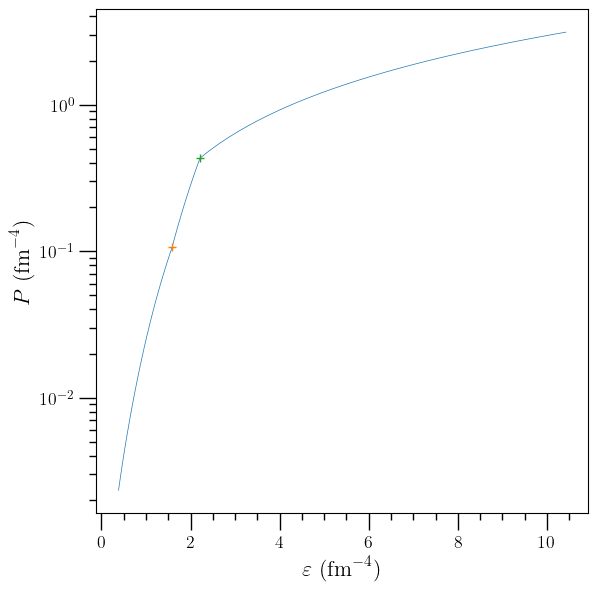

In [25]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.colbar=False
    pb.logx=False
    pb.logy=True
    pb.plot([tab,'ed','pr'])
    pb.xtitle(r'$ \varepsilon~(\mathrm{fm}^{-4}) $')
    pb.ytitle(r'$ P~(\mathrm{fm}^{-4}) $')
    pb.point(ed32,pr32,marker='+')
    pb.point(edlast,prlast,marker='+')
    pb.show()
    plot.close()

Construct an EOS object for the TOV solver (see https://awsteiner.org/code/o2scl/html/class/eos_tov_interp.html for the C++ documentation and https://awsteiner.org/code/o2sclpy-dev/eos.html#class-eos-tov-interp for the Python interface). Add the default neutron star crust.

In [26]:
eti=o2sclpy.eos_tov_interp()
eti.default_low_dens_eos()
eti.read_table(tab,'ed','pr','nb')
eti_ed=eti.get_full_vece().to_numpy()
eti_pr=eti.get_full_vecp().to_numpy()

Plot the full EOS, with the crust

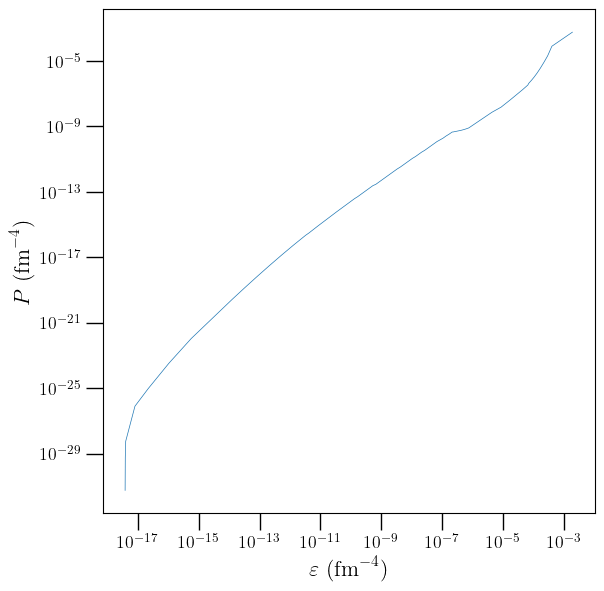

In [27]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.logx=True
    pb.logy=True
    pb.plot([eti_ed,eti_pr])
    pb.xtitle(r'$ \varepsilon~(\mathrm{fm}^{-4}) $')
    pb.ytitle(r'$ P~(\mathrm{fm}^{-4}) $')
    pb.show()
    plot.close()

Compute the full mass-radius curve with the nonrotating TOV solver (see https://awsteiner.org/code/o2scl/html/tov_solve.html and https://awsteiner.org/code/o2sclpy/eos.html#class-tov-solve):

In [28]:
ts=o2sclpy.tov_solve()
ts.set_eos(eti)
ts.verbose=0
ts.mvsr()

0

The results are stored in a ``table_units`` object. We delete table rows larger than the maximum mass.

In [29]:
nonrot=ts.get_results()
prmax=nonrot.get('pr',nonrot.lookup('gm',nonrot.max('gm')))
nonrot.delete_rows_func('pr>'+str(prmax))

Plot the mass-radius curve

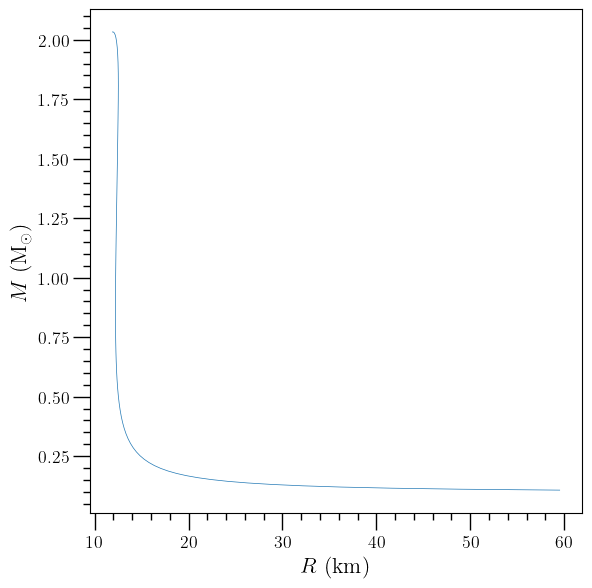

In [30]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.colbar=False
    pb.logx=False
    pb.logy=False
    pb.plot([nonrot,'r','gm'])
    pb.xtitle(r'$ R~(\mathrm{km}) $')
    pb.ytitle(r'$ M~(\mathrm{M}_{\odot}) $')
    pb.show()
    plot.close()

Compute the central energy density of the maximum mass star. Confert to different units.

In [31]:
edmax=nonrot.max('ed')
print('edmax: %7.6e %s' %(edmax,nonrot.get_unit('ed')))
edmax2=cu.convert('Msun/km^3','1/fm^4',edmax)
print('     = %7.6e 1/fm^4' %(edmax2))

edmax: 9.423201e-04 b'Msun/km^3'
     = 5.326586e+00 1/fm^4


Compute the speed of sound over the entire table, and then also the maximum value of the speed of sound in the maximum mass star:

In [34]:
tab.deriv_col('ed','pr','cs2')
cs2_max=0
for i in range(0,tab.get_nlines()):
    #print(i,tab.get('ed',i),edmax2,tab.get('cs2',i))
    if tab.get('ed',i)<edmax2 and tab.get('cs2',i)>cs2_max:
        cs2_max=tab.get('cs2',i)
print('cs2_max: %7.6e' %(cs2_max))

cs2_max: 8.121636e-01


The radius of a 1.4 solar mass neutron star

In [35]:
rad14=nonrot.interp('gm',1.4,'r')
print('rad14 %7.6e' % (rad14))

rad14 1.238311e+01


We need to reformulate the EOS for the rotating neutron star object:

In [36]:
enri=o2sclpy.eos_nstar_rot_interp()
edv=o2sclpy.std_vector()    
prv=o2sclpy.std_vector()    
nbv=o2sclpy.std_vector()

Add all of the rows in the table to the EOS object:

In [38]:
for i in range(0,tab.get_nlines()):
    edv.push_back(tab.get('ed',i))
    prv.push_back(tab.get('pr',i))
    nbv.push_back(tab.get('nb',i))
enri.set_eos_fm(tab.get_nlines(),edv,prv,nbv)

Construct a configuration with a specified central energy density
and axis ratio

In [39]:
nr=o2sclpy.nstar_rot()
nr.verbose=1
nr.set_eos(enri)
nr.fix_cent_eden_axis_rat(2.0e15,0.59)

Output the gravitational mass of this configuration:

In [42]:
print('Mass: %7.6e' % (nr.Mass/nr.MSUN))

Mass: 2.485506e+00
